In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg.lapack as lapack

# Workshop 3 - Time stepping and Poiseuille flow

The aim of this workshop is to write a code that calculates the velocity profile for flow through a channel and then uses this result to obtain the volume flux. We will then consider an unsteady problem, where the velocity develops over some finite time, and thus take a detour into methods for solving time-dependent flows. Notably, in the cases considered analytic solutions will always be available and hence will provide tests for our computed results - next week we will consider more complex problems where such luxuries do not exist. 

## Step 1: Solution via Finite Differences

Last week we learnt how to solve second order differential equations using finite differences.  Here, we have such a problem, with a bulk equation

$$
- G =  \nu\frac{\partial^2 u}{\partial y^2},
$$ 

where $G$ and $\nu$ are constants, and boundary conditions of no-slip at the walls are $u(-W)=u(W)=0$.

- Write down the discrete form of this problem.
- Solve it computationally (probably easiest to adapt your code from last week).
- Plot the result, compare to the analytic solution $u = \frac{G}{2\nu}(W^2-y^2)$ and check for convergence as you increase the number of nodes.

In [2]:
def Analytical(y, G, nu, w):
    u = G/(2*nu)*(w**2 - y**2)
    return u 
    

In [3]:
#Constants
w = 5
G =1
nu = 1


# Number of nodes
N = 50
# Grid spacing
dy = 2*w/(N-1)

# Positions of nodes in domain (for plotting)
u = np.linspace(0,1,N)
y = np.linspace(-w, w, N)

# Set up matrix and vectors for finite difference solve
A = np.zeros((N,N))
b = np.zeros(N)

# Now fill in entries in A and b. Note that python array indexing starts at 0!
# Left boundary
A[0,0] = 1.0
# Interior nodes
for i in range(1,N-1):
    A[i,i-1] = 1*dy**-2
    A[i,i] = -2*dy**-2
    A[i,i+1] = 1*dy**-2
    b[i] = -G/nu
# Right boundary
A[N-1,N-1] = 1

u = Analytical(y, G, nu, w)
# Now use the matrix and vector you assembled to solve (you could also use scipy.linalg.lapack here)
f = np.linalg.solve(A,b)

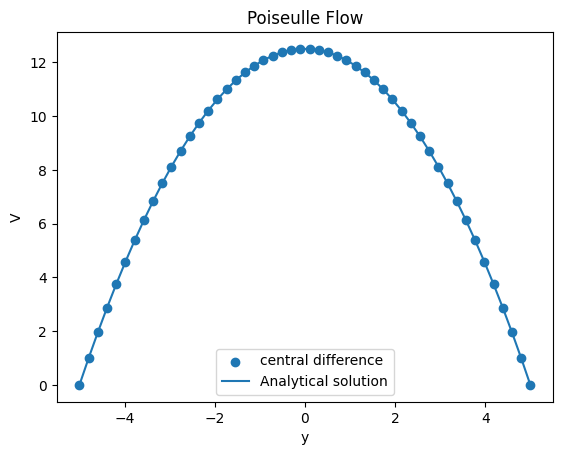

In [4]:
plt.scatter(y, f, label="central difference")
plt.plot(y, u, label="Analytical solution")
plt.ylabel(r"V")
plt.xlabel("y")
plt.title("Poiseulle Flow")
plt.legend()
plt.show()

## Step 2: Volume Flux

To calculate the volume flux $Q$ (per unit length, in 2D) through the channel, we need to take our solution for $u$ and integrate it across the channel, i.e. $Q=\int_{-W}^{W} u \,dy$.  Notably, we only know the value of $u$ at nodes now, so this integral is transformed into a sum.

- Approximate the integral for $Q$ using a sum defined by the Trapezoidal rule and put this into your code.
- Compare your computed solutions to the exact solution $Q=\frac{2W^3 G}{3\nu}$.

In [5]:
def exact_Q(w,G, nu):
    Q = (2*w**3*G)/(3*nu)
    return Q

trap_areas = []
for i in range(N-1):
    area = 0.5*(f[i]+f[i+1])*dy
    trap_areas.append(area)
    
area = np.sum(trap_areas)
real_area = exact_Q(w,G,nu)

print(area)
print(real_area)


83.2986255726772
83.33333333333333


## Step 3:  Startup Flow (Unsteady Flow)

Consider now the unsteady problem
$$
\frac{\partial u}{\partial t} =  G+ \nu\frac{\partial^2 u}{\partial y^2},
$$
in which the flow is initially at rest $u(y,t)=0$ at $t=0$.

There is in fact an analytic solution in this case too (this is a diffusion equation, in our case for momentum), whose first term (of an infinite expansion) is given by
$$
u_{ana} = \frac{W^2 G}{2 \nu}\left[(1-y^2/W^2)-\frac{32}{\pi^3}\cos\left(\frac{\pi y}{2W}\right)\exp(-\pi^2 \nu t/(4 W^2))\right],
$$
that very accurately reproduces the entire solution.  For the derivation, either have a go yourself or look at [this article](https://aip.scitation.org/doi/pdf/10.1063/1.4916621?class=pdf) (note there may be better derivations, but I'm yet to find them - let me know if you do!).

To solve this problem computationally, we must consider how to 'time step', i.e. how to take discrete steps in time at which we approximate our solution.  To do so we must take a brief sidestep and consider different time stepping methods.

### Explicit vs Implicit Time Stepping

We consider here only the simplest time stepping techniques, known as forward and backward Euler methods, which are equivalent to forward and backward differences we have already seen for spatial discretisations.  They are first order accurate, with errors proportional to the time step $\Delta t$, but they will give us all the insight we need (there is nothing conceptually more complex with higher order methods).

Consider a PDE of the form 
$$
\frac{\partial u}{\partial t} = F(u,t)
$$

where in our case $F(u,t)= G + \nu\frac{\partial^2 u}{\partial y^2}$.  Our aim is to now compute $u$ at discrete times $t=\Delta t, 2\Delta t,..., T=M\Delta t$ where $\Delta t$ is the time step, $T$ is the total period and $M$ is the number of steps.  In both forward and backward Euler methods the time derivative is discretised as 

$$
\frac{\partial u}{\partial t} \approx \frac{u^{j+1}-u^{j}}{\Delta t}
$$

where $u^j$ is the solution at the current time step and $u^{j+1}$ is the solution at the next time step, which we need to find.  The difference between forward and backward Euler methods is in how we represent $F$.  If we approximate this by its value at the $j$ level, we have a forward Euler method

$$
\frac{u^{j+1} - u^{j}}{\Delta t} =  F^j(u,t)\qquad\implies\qquad u^{j+1} =  u^{j} + \Delta t F^j(u,t)
$$

which is known as an explicit method, because we have an explicit formula for the solution at the next time step given values at the current time step (i.e. this is super simple to apply!). 

In contrast, if we used the backward Euler method we would have 

$$
\frac{u^{j+1} - u^{j}}{\Delta t} =  F^{j+1}(u,t)
$$

and we are unable to rearrange the equation to find an explicit formula for $u^{j+1}$ given information at level $j$, i.e. we will end up needing to solve a system of linear equations at every time step for $u^{j+1}$.  This is called an implicit method.

It may seem like a 'no brainer' to use the simpler explicit method, but alas there is a complication.  For the explicit method we will see that our time step $\Delta t$ cannot be arbitrarily large as the method becomes unstable, whereas the implicit method is always stable (though not necessarily accurate).

## Start-Up Flow

Consider now the generation of a Poiseuille flow from an initially stationary fluid - i.e. consider how  the velocity profile grows once a pressure gradient is 'switched on'.

Recalling that each value $u$ now has a spatial $i$ and temporal $j$ position, we represent it as $u^{j}_i$, so that, e.g., $u^{12}_3$ would be the value of $u$ at the third node at time step 12.  Then using the forward Euler method we find that
$$
u_i^{j+1} =  u_i^{j} + \Delta t F_i^j(u,t) = u_i^{j} + \Delta t\left(G+ \nu\frac{u^j_{i-1} + u^j_{i+1} - 2u^j_i }{h^2}\right)
$$
which is valid for  $i=2,...,n-1$ (as at the boundaries we have $u^j_1=u^j_n=0$) and $j=2,...,m$ (as our initial condition gives that $u^1_i=0$ for all $i$).

Note that in a sense this is easier than solving the steady problem, as we don't have to solve a set of linear equations, we just know the next solution by calculating information about the previous step (the second spatial derivative of $u$ in our case).  This makes this method very fast.  

However, as you will see, if $\Delta t$ is not sufficiently small, then the explicit method becomes unstable.  Crudely, one can think of this as happening when 'information' about the solution travels out of a grid cell during a time step - i.e. if the characteristic speed at which the solution propagates is greater than $h/\Delta t$.  This is called the  'Courant-Friedrichs-Lewy' condition (more details can be found online) and in our case means that we require 
$$
\frac{\nu\Delta t}{h^2}\ll 1
$$
to ensure stability.  For example, we may choose a time step $\Delta t = 0.1 h^2 / \nu$ and one can see immediately that for small mesh sizes $h\ll1$ this can be very restrictive on the $\Delta T$ we can take, which is a particular problem for multiscale problems.

Notably, after a certain time (you can estimate how long from the analytic solution where the decay of the unsteady term goes like $exp(-\pi^2 \nu t/(4 W^2)$ so that we need $t> 4W^2/\pi^2 \nu$ for this term to be negligible), one should approach the steady state and in fact this approach of time stepping can be used as a general method for obtaining steady states (particularly when the problem is nonlinear and a good initial guess is hard to come by).

## Tasks

I would hope that everyone will be able to
- Solve Poiseuille flow in a channel numerically;
- Integrate the velocity to obtain the volume flux; and
- Solve Start-Up Flow using an explicit method.
In all of the above examples, you should compare to analytic solutions as verification of your code.

For the more ambitious, I would suggest:
- Solving Start-Up flow using the backward Euler method, i.e. an implicit solver.
- Considering second order accurate time stepping schemes, e.g. using a one-sided Taylor expansion to derive a second order accurate implicit method, or using Crank Nicolson method where the RHS is approximated as $\frac{1}{2}(F_i^j + F_i^{j+1})$.
- Consider using the symmetry condition along the centre-line, so that you only have to compute half of the solution.
- Consider the case in which one boundary moves parallel to itself and show that the analytic solution is a combination of Couette and Poiseuille flow.

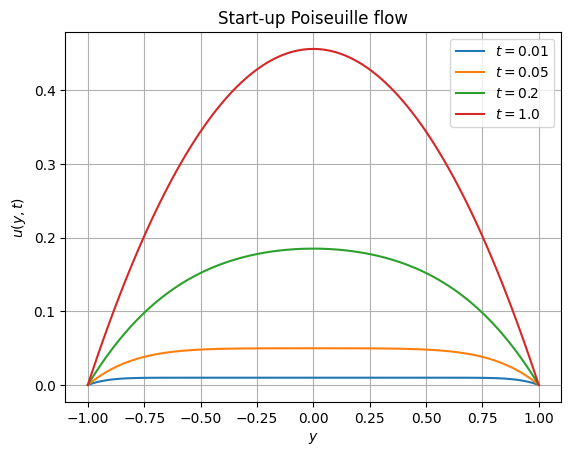

In [13]:
# parameters
W = 1.0
G = 1.0
nu = 1.0
N = 101

y = np.linspace(-W, W, N)
dy = y[1] - y[0]

dt = 0.5 * dy**2 / nu
times = [0.01, 0.05, 0.2, 1.0]

def step(u):
    u_new = u.copy()
    u_new[1:-1] = u[1:-1] + dt * (
        G + nu * (u[:-2] + u[2:] - 2*u[1:-1]) / dy**2
    )
    u_new[0] = 0
    u_new[-1] = 0
    return u_new

plt.figure()

for T in times:
    u = np.zeros_like(y)
    nsteps = int(T / dt)
    for _ in range(nsteps):
        u = step(u)
    plt.plot(y, u, label=fr"$t={T}$")

plt.xlabel(r"$y$")
plt.ylabel(r"$u(y,t)$")
plt.title("Start-up Poiseuille flow")
plt.legend()
plt.grid(True)
plt.show()